In [1]:
# -*- coding: utf-8 -*-
import sys; print('Python %s on %s' % (sys.version, sys.platform))
import os
import time
import json
from glob import glob, iglob
from tqdm import tqdm
from random import random
import matplotlib.pyplot as plt

import numpy as np; print('numpy', np.__version__)
import pandas as pd; print('pandas', pd.__version__)
import cv2; print('opencv2', cv2.__version__)

import settings
import helper
import visual

Python 3.6.8 (default, Jan 14 2019, 11:02:34) 
[GCC 8.0.1 20180414 (experimental) [trunk revision 259383]] on linux
numpy 1.16.4
pandas 0.24.2
opencv2 4.1.0


# 1. Load Meta File and Annotation

In [2]:
df_meta_train = pd.read_csv(filepath_or_buffer=settings.PREPROCESS_TRAIN_META_FILE, index_col=['seriesuid'])
df_meta_train.index = df_meta_train.index.astype('str')

In [3]:
df_meta_train.head(5)

,width,height,slice,originX,originY,originZ,spacingX,spacingY,spacingZ,segmented_lung,segmented_medi
seriesuid,,,,,,,,,,,
689704,350,350,285,-175.384491,-174.658203,-346.053955,0.683594,0.683594,5.0,0.0,0.0
680464,350,350,300,-174.658203,-174.658203,1195.953613,0.683594,0.683594,5.0,0.0,0.0
651264,350,350,295,-162.311188,-174.658203,-91.186157,0.683594,0.683594,5.0,0.0,0.0
401934,360,360,265,-174.000000,-180.000000,-760.400024,0.703125,0.703125,5.0,0.0,0.0
389624,400,400,296,-205.662994,-199.804306,-816.500000,0.782000,0.782000,8.0,0.0,0.0


In [4]:
df_annotation = pd.read_csv(filepath_or_buffer=settings.PREPROCESS_ANNOTATION_FILE, index_col=['seriesuid'])
df_annotation.index = df_annotation.index.astype('str')
print('annotation:', df_annotation.shape, 'distinct lung:', len(set(df_annotation.index)))

annotation: (12218, 16) distinct lung: 1436


In [5]:
df_annotation.sample(10)

,width,height,slice,vcoordX,vcoordY,vcoordZ,diameterX,diameterY,diameterZ,originX,originY,originZ,spacingX,spacingY,spacingZ,label
seriesuid,,,,,,,,,,,,,,,,
656319,350,350,270,193.115234,163.037109,255.0,9.570312,8.203125,5.000000,-182.647446,-174.658203,-178.644531,0.683594,0.683594,5.000000,32.0
670805,458,458,315,256.283203,174.433594,175.0,25.046875,15.207031,5.000000,-229.279037,-228.552734,-911.192749,0.894531,0.894531,5.000000,31.0
671869,321,321,345,118.494141,205.954102,305.0,6.896484,11.285156,4.994397,-160.186523,-300.186523,-738.619019,0.626953,0.626953,4.994397,5.0
398850,351,351,278,162.687501,179.127501,120.0,15.070000,10.960000,7.500000,-163.342499,-175.342499,-270.000000,0.685000,0.685000,7.500000,32.0
512053,324,324,289,252.808784,185.730609,178.0,8.859382,11.390634,8.500000,-105.099998,-162.000000,-802.500000,0.632813,0.632813,8.500000,1.0
676121,344,344,295,185.773438,167.632812,248.0,17.468750,28.218750,20.000000,-177.664062,-311.664062,-743.400024,0.671875,0.671875,5.000000,31.0
672344,350,350,300,85.107422,170.214844,235.0,9.570312,7.519531,5.000000,-165.942642,-174.658203,-407.866821,0.683594,0.683594,5.000000,1.0
689549,353,353,325,158.229492,133.409180,232.0,26.199219,37.230469,9.992937,-167.155273,-316.155273,-723.573975,0.689453,0.689453,4.996469,5.0
407431,350,350,265,124.072266,248.828125,15.0,8.203125,17.089844,5.000000,-168.847839,-174.658203,1256.291626,0.683594,0.683594,5.000000,5.0


In [6]:
lungs = list(set(df_annotation.index))
print('distinct lungs in annotation:', len(lungs))

distinct lungs in annotation: 1436


# 2. Generate Negative Labels

In [7]:
IS_GENERATE = True

In [8]:
if IS_GENERATE:
    list_neg = []
    for uid in tqdm(lungs):
        labels = df_annotation.loc[[uid]] # dataframe
        meta = df_meta_train.loc[uid] # slice
        
        for i in range(settings.GENERATE_NEGS_PER_LUNG):
            vcoordX, vcoordY, vcoordZ = random()*meta.width, random()*meta.height, random()*meta.slice
            # print(vcoordX, vcoordY, vcoordZ)
            
            flag_pass = True
            if len(labels) > 0:
                for idx, item in labels.iterrows():
                    dist = np.linalg.norm(np.array([vcoordX, vcoordY, vcoordZ]) - np.array([item.vcoordX, item.vcoordY, item.vcoordZ]))
                    if dist <= settings.CUBE_POS_SIZE + settings.CUBE_NEG_SIZE:
                        flag_pass = False
                        break
            
            if flag_pass:
                neg = {}
                neg['seriesuid'] = uid
                neg['width'] = meta.width
                neg['height'] = meta.height
                neg['slice'] = meta.slice
                neg['vcoordX'] = vcoordX
                neg['vcoordY'] = vcoordY
                neg['vcoordZ'] = vcoordZ
                list_neg.append(neg)
                

100%|██████████| 1436/1436 [00:47<00:00, 30.17it/s]


In [9]:
if IS_GENERATE:
    df_neg = pd.DataFrame(list_neg, columns=['seriesuid','width','height','slice','vcoordX','vcoordY','vcoordZ'])
    df_neg = df_neg.set_index('seriesuid')
    df_neg.index = df_neg.index.astype('str')
    df_neg['width'] = df_neg['width'].astype('int')
    df_neg['height'] = df_neg['height'].astype('int')
    df_neg['slice'] = df_neg['slice'].astype('int')
    
    print('total:', len(df_neg), 'lung:', len(set(df_neg.index)))
    
    df_neg.to_csv(settings.PREPROCESS_CANDIDATE_FILE, encoding='utf-8')
    

total: 20400 lung: 1430


# 3. Negative Samples Extraction

In [10]:
IS_EXTRACTION = True
if not os.path.exists(settings.PREPROCESS_NEG_DIR):
    os.mkdir(settings.PREPROCESS_NEG_DIR)
    os.mkdir(settings.PREPROCESS_NEG_DIR + 'lung/')
    os.mkdir(settings.PREPROCESS_NEG_DIR + 'medi/')
    
df_candidate = pd.read_csv(filepath_or_buffer=settings.PREPROCESS_CANDIDATE_FILE, index_col=['seriesuid'])
df_candidate.index = df_candidate.index.astype('str')
print('candidate:', df_candidate.shape, 'distinct lung:', len(set(df_candidate.index)))

candidate: (20400, 6) distinct lung: 1430


In [11]:
if IS_EXTRACTION:
    for uid in tqdm(lungs):
        if uid not in df_candidate.index:
            continue
            
        labels = df_candidate.loc[[uid]]

        lung_l, mask_l = helper.load_lung_array(uid, int(labels['width'].values[0]), int(labels['height'].values[0]), int(labels['slice'].values[0]), wtype='lung')
        lung_m, mask_m = helper.load_lung_array(uid, int(labels['width'].values[0]), int(labels['height'].values[0]), int(labels['slice'].values[0]), wtype='medi')
        
        lung_l = lung_l*(mask_l>0)
        lung_m = lung_m*(mask_m>0)
        
        count = 0
        for idx, item in labels.iterrows():
            # patch without mask
            if count % 2 == 0:
                lung = lung_l
                wtype = 'lung'
            elif count % 2 == 1:
                lung = lung_m
                wtype = 'medi'
                
            cube = helper.get_cube_from_lung_array(lung, item.vcoordX, item.vcoordY, item.vcoordZ, 
                                                   block_size=settings.CUBE_NEG_SIZE)
            if np.sum(cube) > settings.THRESHOLD_VALID_CUBE:
                helper.save_cube_img(
                    f'{settings.PREPROCESS_NEG_DIR}{wtype}/{idx}_x{int(item.vcoordX)}_y{int(item.vcoordY)}_z{int(item.vcoordZ)}.png', 
                    cube, rows=8, cols=8)
            
            count += 1
            

100%|██████████| 1436/1436 [1:02:44<00:00,  2.53s/it]


# 4. Validate the Negative Samples

In [12]:
print(len(df_candidate), len(glob(settings.PREPROCESS_NEG_DIR + '*/*.png')))

20400 9585


In [16]:
EXAMPLE_SERIESUID = '421207'
WTYPE = 'medi'

In [17]:
labels = df_candidate.loc[[EXAMPLE_SERIESUID]]
print('labels:', len(labels))

labels: 5


In [21]:
if len(labels) > 0:
    for idx, item in labels.iterrows():
        filename = f'{idx}_x{int(item.vcoordX)}_y{int(item.vcoordY)}_z{int(item.vcoordZ)}.png'
        if os.path.exists(settings.PREPROCESS_NEG_DIR + 'medi/' + filename):
            cube = helper.load_cube_img(settings.PREPROCESS_NEG_DIR + 'medi' + '/' + filename, rows=8, cols=8)
        elif os.path.exists(settings.PREPROCESS_NEG_DIR + 'lung/' + filename):
            cube = helper.load_cube_img(settings.PREPROCESS_NEG_DIR + 'lung' + '/' + filename, rows=8, cols=8) 
        else:
            continue
        
        assert cube.shape == (64, 64, 64)
        print(filename, '\n', cube)
        print('--'*30)

421207_x0_y269_z56.png 
 [[[  0   0   0 ...   0   0   0]
  [  0   0   0 ...   0   0   0]
  [  0   0   0 ...   0   0   0]
  ...
  [  0   0   0 ...   0   0   0]
  [  0   0   0 ...   0   0   0]
  [  0   0   0 ...   0   0   0]]

 [[  0   0   0 ...   0   0   0]
  [  0   0   0 ...   0   0   0]
  [  0   0   0 ...   0   0   0]
  ...
  [  0   0   0 ...   0   0   0]
  [  0   0   0 ...   0   0   0]
  [  0   0   0 ...   0   0   0]]

 [[  0   0   0 ...   0   0   0]
  [  0   0   0 ...   0   0   0]
  [  0   0   0 ...   0   0   0]
  ...
  [  0   0   0 ...   0   0   0]
  [  0   0   0 ...   0   0   0]
  [  0   0   0 ...   0   0   0]]

 ...

 [[  0   0   0 ... 105  97  80]
  [  0   0   0 ...  79  69  80]
  [  0   0   0 ...  51  57  68]
  ...
  [  0   0   0 ...   0   0   0]
  [  0   0   0 ...   0   0   0]
  [  0   0   0 ...   0   0   0]]

 [[  0   0   0 ... 103  94  76]
  [  0   0   0 ...  78  70  77]
  [  0   0   0 ...  55  59  69]
  ...
  [  0   0   0 ...   0   0   0]
  [  0   0   0 ...   0   0   0]
  [

# 5. Visual Samples By Labels

In [22]:
EXAMPLE_SERIESUID = '660577'

/tf/tianchi2019/preprocess/neg/medi/660577_x33_y152_z306.png 1149005


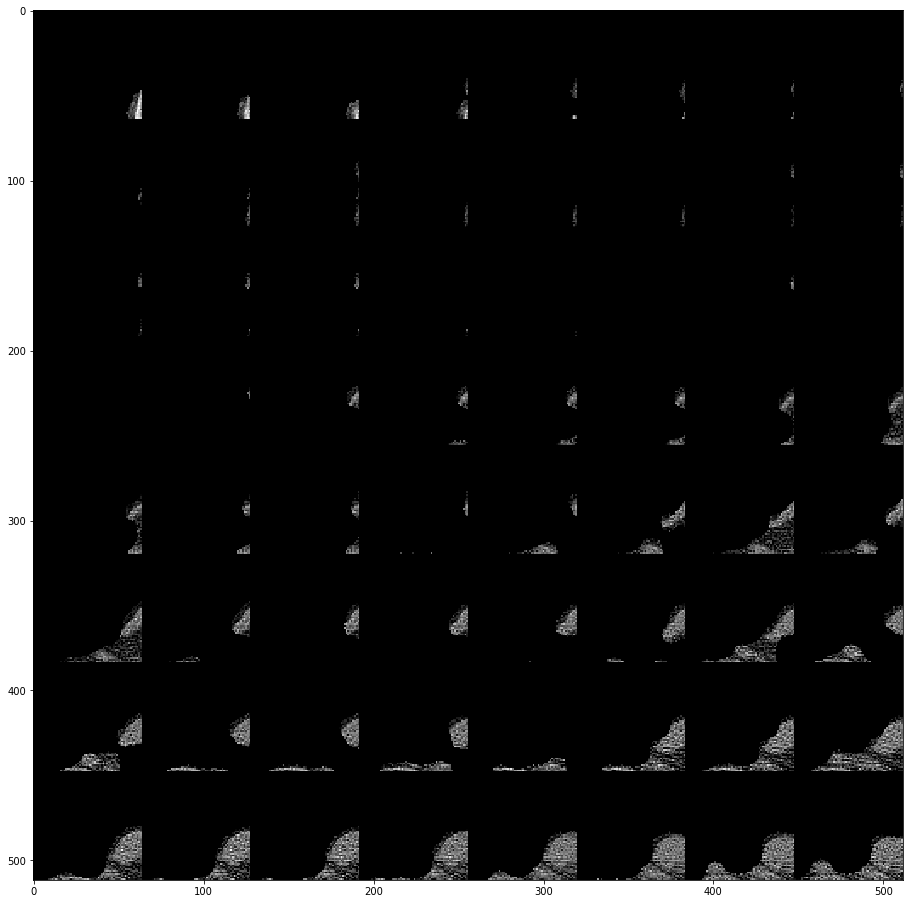

/tf/tianchi2019/preprocess/neg/medi/660577_x326_y327_z313.png 32289


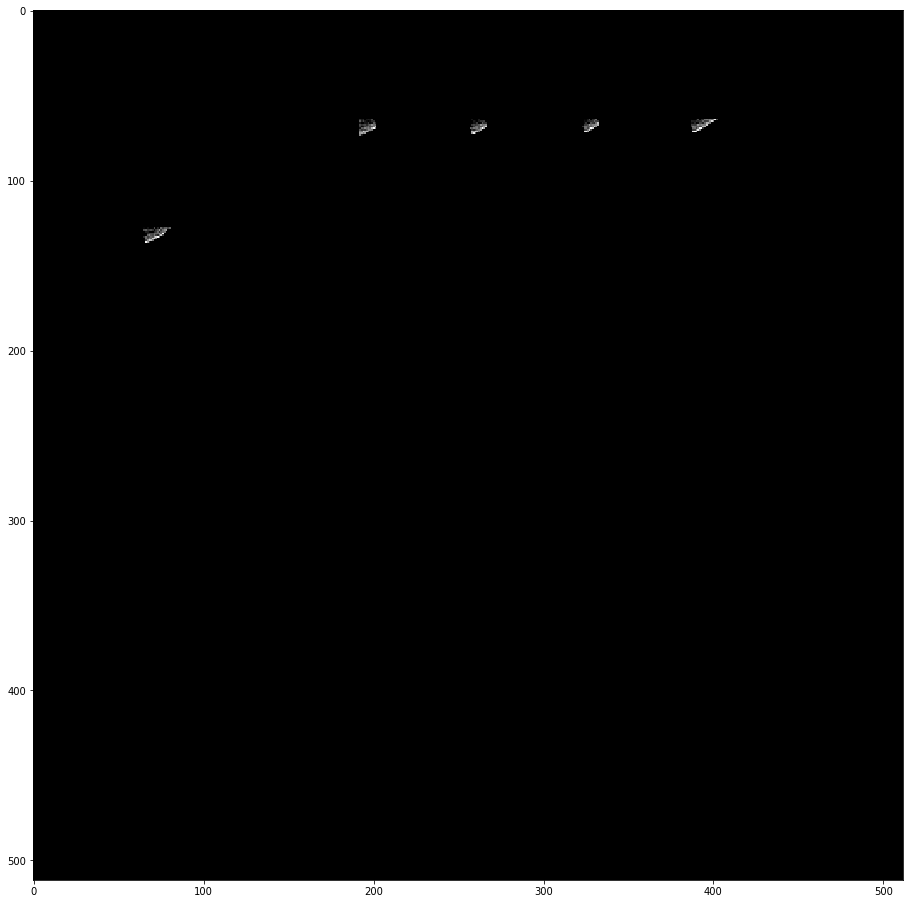

/tf/tianchi2019/preprocess/neg/medi/660577_x322_y157_z37.png 472631


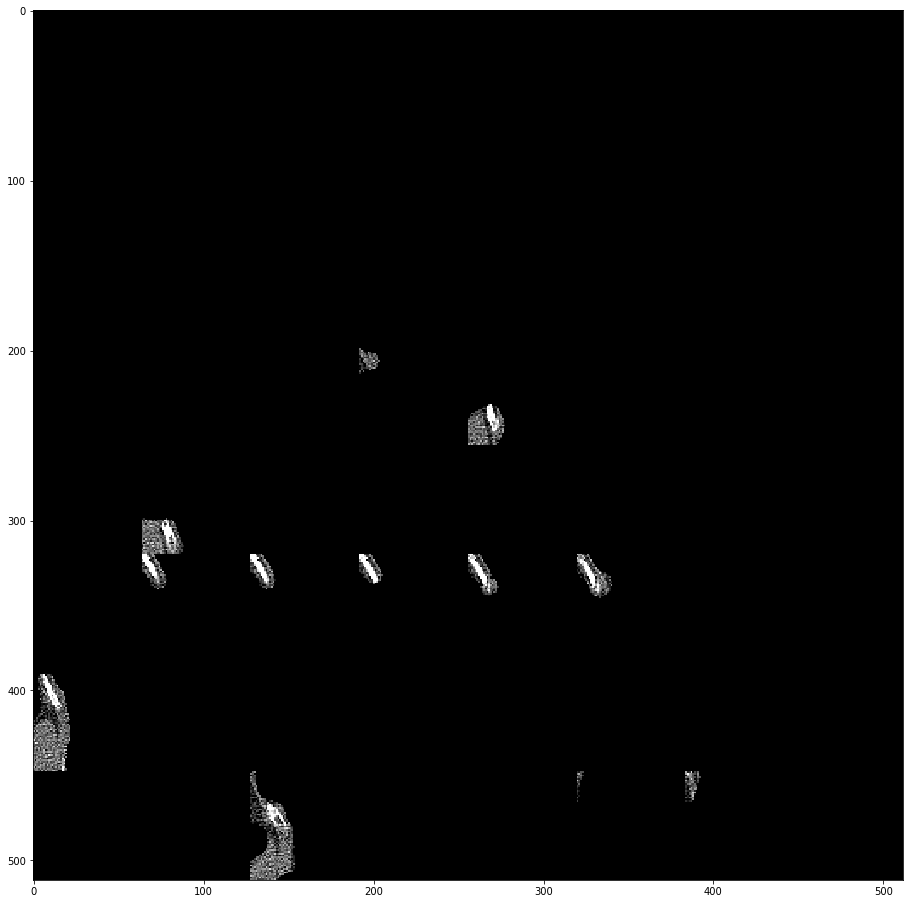

/tf/tianchi2019/preprocess/neg/medi/660577_x315_y115_z273.png 3576


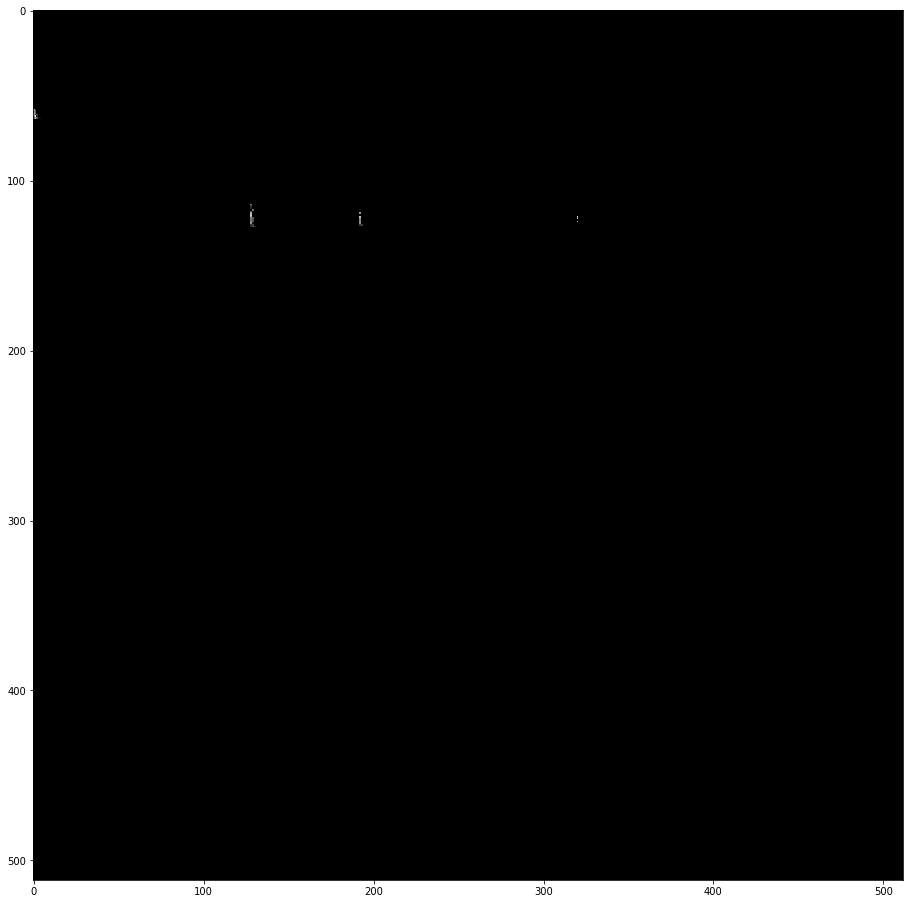

/tf/tianchi2019/preprocess/neg/medi/660577_x145_y321_z316.png 3419103


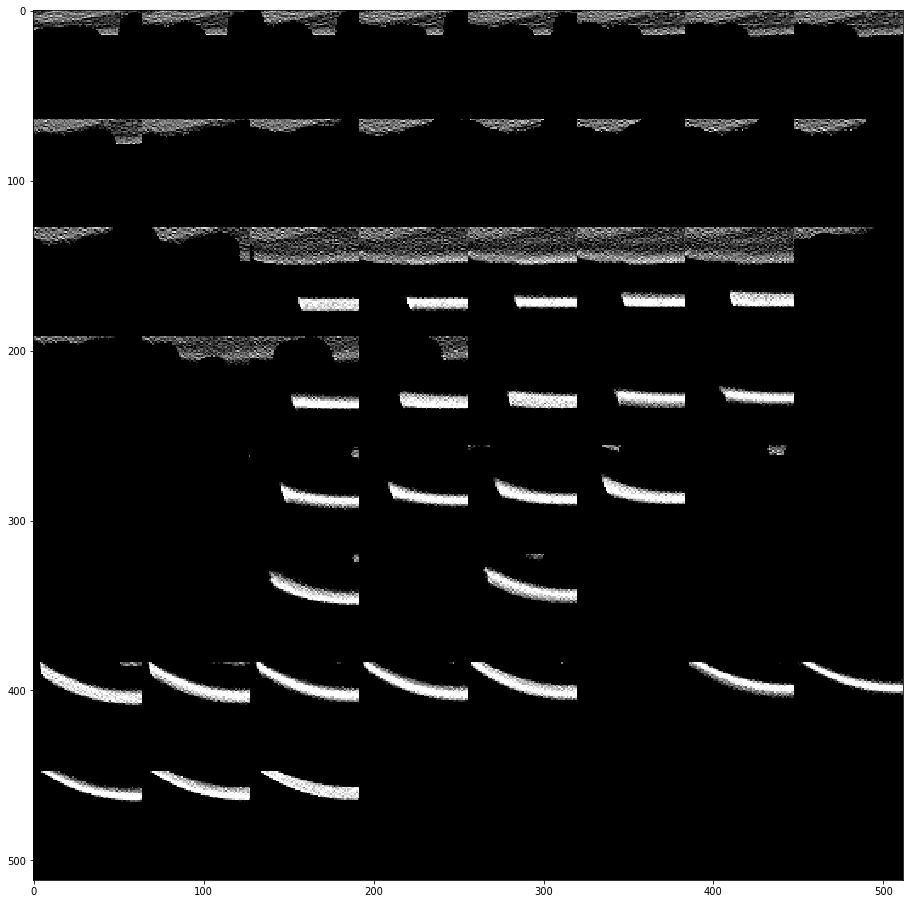

/tf/tianchi2019/preprocess/neg/medi/660577_x122_y301_z104.png 2064897


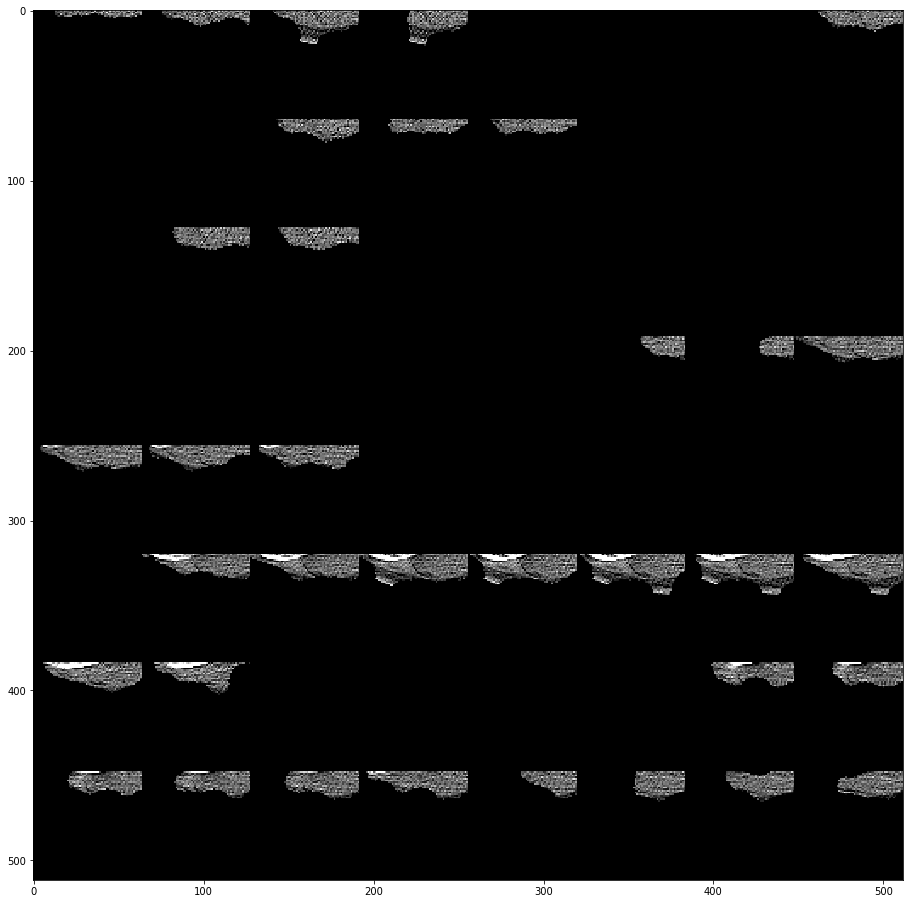

In [23]:
for img_file in iglob(settings.PREPROCESS_NEG_DIR + 'medi/' + f'{EXAMPLE_SERIESUID}*.png'):
    img = cv2.imread(img_file, cv2.IMREAD_GRAYSCALE)
    print(img_file, np.sum(img))
    fig, axs = plt.subplots(1, 1, figsize=(16, 16))
    axs.imshow(img, cmap='gray')
    plt.show()

/tf/tianchi2019/preprocess/neg/lung/660577_x312_y264_z108.png 906917


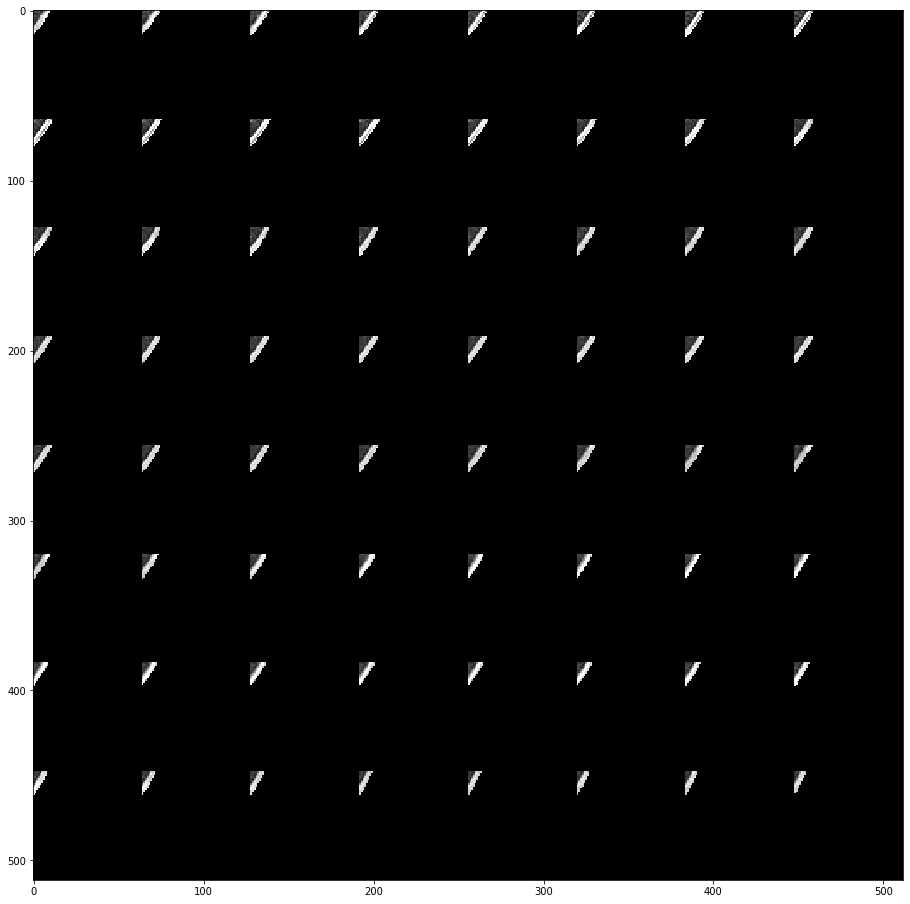

/tf/tianchi2019/preprocess/neg/lung/660577_x70_y270_z77.png 3701772


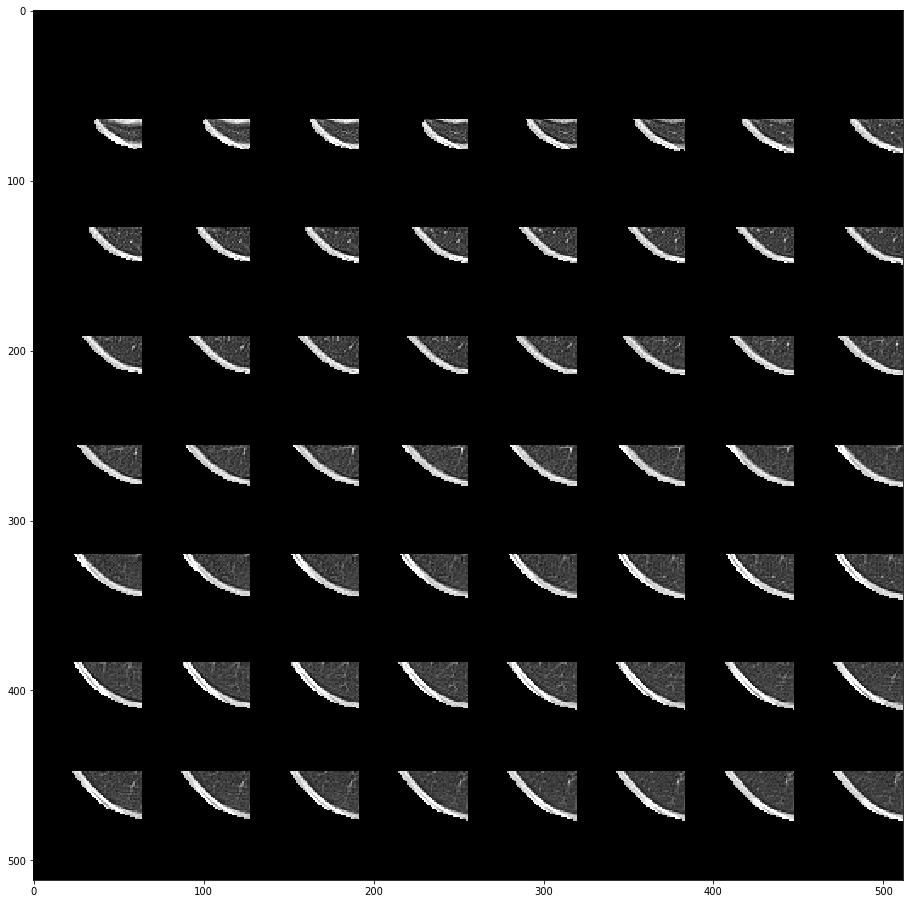

In [25]:
for img_file in iglob(settings.PREPROCESS_NEG_DIR + 'lung/' + f'{EXAMPLE_SERIESUID}*.png'):
    img = cv2.imread(img_file, cv2.IMREAD_GRAYSCALE)
    print(img_file, np.sum(img))
    fig, axs = plt.subplots(1, 1, figsize=(16, 16))
    axs.imshow(img, cmap='gray')
    plt.show()